In [1]:
import os
import gc
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit
from joblib import dump, load
import scipy.stats as stats
import seaborn as sns
tqdm.pandas()

import sys
sys.path.insert(0, '../../')

from utils.preprocess import *

In [2]:

folder = '../../../data/'

art_df = pd.read_csv(os.path.join(folder, "articles.csv"))
cus_df = pd.read_csv(os.path.join(folder, "customers.csv"))
trans_df = pd.read_csv(os.path.join(folder, "transactions_train.csv"))

trans_df = make_weeknum_col(trans_df)
# week_num 0 is latest week of the transaction
train_df, val_df = split_train_valid(trans_df, 0)
# val_df = valid2submission(val_df)


In [3]:
use_cols = ['t_dat', 'customer_id', 'article_id']
train_df = train_df[use_cols]

In [4]:
# https://www.kaggle.com/code/lichtlab/do-customers-buy-the-same-products-again
art_df['idxgrp_idx_prdtyp'] = art_df['index_group_name'] + '_' + art_df['index_name'] + '_' + art_df['product_type_name'] 
display(art_df.astype(str).describe().T)

temp_df = art_df.groupby('prod_name')['idxgrp_idx_prdtyp'].count()
print('같은 prod_name에서의 다른 idxgrp_idx_prdtyp:');print()
print(list(temp_df[temp_df == 2].index)[:10])
print();print()
print('같은 idxgrp_idx_prdtyp에서의 다른 prod_name:');print()
print('', list(art_df[art_df.idxgrp_idx_prdtyp == art_df.idxgrp_idx_prdtyp.iloc[0]]['prod_name'].unique())[:10])

,count,unique,top,freq
article_id,105542,105542,108775015,1
product_code,105542,47224,783707,75
prod_name,105542,45875,Dragonfly dress,98
product_type_no,105542,132,272,11169
product_type_name,105542,131,Trousers,11169
product_group_name,105542,19,Garment Upper body,42741
graphical_appearance_no,105542,30,1010016,49747
graphical_appearance_name,105542,30,Solid,49747
colour_group_code,105542,50,9,22670
colour_group_name,105542,50,Black,22670


같은 prod_name에서의 다른 idxgrp_idx_prdtyp:

['& Denim Boyfriend LW denim', '&DENIM Shaping bootcut', '&DENIM Skinny RW milo zip', '&DENIM+ Girlfriend RW', '&DENIM+ Jacket oversized', '&Denim Lou shirtdress.', '&Denim+ Embrace HW Ankle', '&Denim+ Embrace HW Trash', '&Denim+ Lou shirtdress', '&denim festive HW ankle']


같은 idxgrp_idx_prdtyp에서의 다른 prod_name:

 ['Strap top', 'Strap top (1)', 'Beyonce cropped tank', 'Moa tanktop', 'Halter', 'Jess', 'cooper tank', 'Tika (1)', 'Tika', 'Robin']


In [5]:

use_cols = ['article_id', 'prod_name', 'idxgrp_idx_prdtyp']
sample_art_df = art_df[use_cols]
train_df = pd.merge(train_df, sample_art_df, how='left', on='article_id')
train_df.head()

,t_dat,customer_id,article_id,prod_name,idxgrp_idx_prdtyp
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,Atlanta Push Body Harlow,Ladieswear_Lingeries/Tights_Underwear body
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,Rae Push (Melbourne) 2p,Ladieswear_Lingeries/Tights_Bra
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,Inca Jumper,Divided_Divided_Sweater
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,W YODA KNIT OL OFFER,Ladieswear_Ladieswear_Sweater
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,W YODA KNIT OL OFFER,Ladieswear_Ladieswear_Sweater


In [6]:
train_df['t_dat'] = pd.to_datetime(train_df['t_dat'])
train_df['trans_idx'] = train_df.index

print("총 거래 수", len(train_df))
aid_train_df = train_df.drop_duplicates(subset=["t_dat", "customer_id", "article_id"], keep='last')
pname_train_df = train_df.drop_duplicates(subset=["t_dat", "customer_id", "prod_name"], keep='last')
idxgrp_train_df = train_df.drop_duplicates(subset=["t_dat", "customer_id", "idxgrp_idx_prdtyp"], keep='last')
print("중복제거")
print(f"article_id: {len(aid_train_df)}")
print(f"prod_name: {len(pname_train_df)}")
print(f"idxgrp_idx_prdtyp : {len(idxgrp_train_df)}")

## 다른 열 유지 시, mean on price, max on channel_id
## 같은 날짜 같은 고객 같은 상품 수량 2 이상 구매 합치기
# train_df = train_df.groupby(['article_id', 'customer_id','t_dat'])
# price_df = train_df.price.mean()
# price_df = pd.DataFrame(price_df)
# channel_df = train_df.sales_channel_id.max()
# train_df = pd.merge(price_df, channel_df, left_index=True, right_index=True, how="left")
# train_df = train_df.reset_index()




총 거래 수 31548013
중복제거
article_id: 28358603
prod_name: 26462145
idxgrp_idx_prdtyp : 21149355


In [7]:
def make_time_interval_col(train_df, col='article_id'):
    train_df = train_df.set_index(['customer_id', col])
    train_df = train_df.sort_values('t_dat')
    train_df = train_df.sort_index()

    train_df[f'{col}_lastdate'] = train_df.groupby(level=[0,1])['t_dat'].shift(1)
    train_df[f'{col}_dist'] = (train_df['t_dat'] - train_df[f'{col}_lastdate']).dt.days

    train_df = train_df.reset_index()
    return train_df

# day_intervals = train_df.loc[train_df['dist'].notna(), 'dist'].values

In [8]:
aid_train_df = make_time_interval_col(aid_train_df, 'article_id')
pname_train_df = make_time_interval_col(pname_train_df, 'prod_name')
idxgrp_train_df = make_time_interval_col(idxgrp_train_df, 'idxgrp_idx_prdtyp')

## RCP - Repeat Customer Probability

- 상품 A를 2번 이상 고매한 고객의 수 / 상품 A를 최소 한번이라도 구매한 고객 수

- Formula:\
$$ P_{A_i}(t_{k+1}|t_{1},t_{2}, ... t_{k}) \approx Q(A_{i}) \approx RCP_{A_{i}} = {{\mathrm{\# \ of \ customers \ who \ bought \ product \ A_{i} \ more \ than \ once}}\over{\mathrm{\# \ of \ customers \ who \ bought \ product \ A\_{i} \ at \ least \ once}}} $$

In [9]:
def groupby_cid_artinfo(transaction_df, article_info):
    grouped = transaction_df.groupby([f'{article_info}', 'customer_id'])['t_dat'].count().reset_index()
    grouped = grouped.rename(columns={'t_dat': 'cnt'})
    grouped = grouped.sort_values('cnt', ascending= False)
    return grouped

def make_rcp_df(grouped_df, article_info):

    denom = pd.DataFrame(grouped_df.groupby(f'{article_info}')['customer_id'].nunique()).reset_index()
    denom = denom.rename(columns={'customer_id': 'denom_customer'})

    numer = pd.DataFrame(grouped_df[grouped_df.cnt > 1].groupby(f'{article_info}')['customer_id'].nunique()).reset_index()
    numer = numer.rename(columns={'customer_id': 'num_customer'})

    rcp_df = pd.merge(denom, numer, on= f'{article_info}')
    rcp_df['rcp'] = rcp_df['num_customer']/rcp_df['denom_customer']
    return rcp_df



In [10]:
aid_g_df = groupby_cid_artinfo(aid_train_df, 'article_id')
pname_g_df = groupby_cid_artinfo(pname_train_df, 'prod_name')
prdtyp_g_df = groupby_cid_artinfo(idxgrp_train_df, 'idxgrp_idx_prdtyp')

In [11]:
aid_g_df = make_rcp_df(aid_g_df, 'article_id')
pname_g_df = make_rcp_df(pname_g_df, 'prod_name')
prdtyp_g_df = make_rcp_df(prdtyp_g_df, 'idxgrp_idx_prdtyp')

In [12]:
def describe_vis(rcp_df, color = 'r'):
    numeric_cols = ['denom_customer', 'num_customer', 'rcp']
    display(rcp_df[numeric_cols].describe())
    rcp_df = rcp_df.sort_values('rcp')
    rcp_df['rcp'].hist(bins=500, color = color)


,denom_customer,num_customer,rcp
count,62599.000000,62599.000000,62599.000000
mean,420.078596,18.068228,0.044966
std,779.697395,62.415162,0.045307
min,1.000000,1.000000,0.001621
25%,67.000000,2.000000,0.022079
50%,182.000000,5.000000,0.035354
75%,471.000000,16.000000,0.055138
max,32068.000000,6378.000000,1.000000


,denom_customer,num_customer,rcp
count,30807.000000,30807.000000,30807.000000
mean,785.446165,54.099523,0.051629
std,2165.559865,284.186002,0.044378
min,1.000000,1.000000,0.001621
25%,77.000000,2.000000,0.027027
50%,213.000000,8.000000,0.043478
75%,649.000000,29.000000,0.065114
max,76918.000000,20803.000000,1.000000


,denom_customer,num_customer,rcp
count,469.000000,469.000000,469.000000
mean,27649.420043,8272.590618,0.098492
std,72425.456837,30127.965554,0.090103
min,4.000000,1.000000,0.004082
25%,515.000000,18.000000,0.040929
50%,2646.000000,169.000000,0.068543
75%,12991.000000,1429.000000,0.119331
max,520563.000000,259551.000000,0.500000


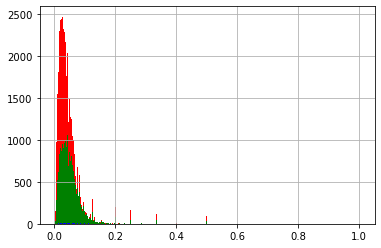

In [13]:
describe_vis(aid_g_df, 'r')
describe_vis(pname_g_df, 'g')
describe_vis(prdtyp_g_df, 'b')

,denom_customer,num_customer,rcp
count,469.000000,469.000000,469.000000
mean,27649.420043,8272.590618,0.098492
std,72425.456837,30127.965554,0.090103
min,4.000000,1.000000,0.004082
25%,515.000000,18.000000,0.040929
50%,2646.000000,169.000000,0.068543
75%,12991.000000,1429.000000,0.119331
max,520563.000000,259551.000000,0.500000


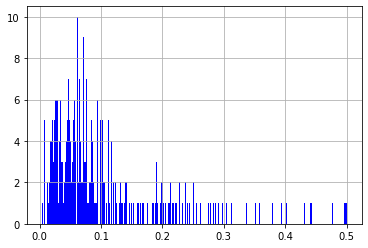

In [14]:
describe_vis(prdtyp_g_df, 'b')

In [15]:
prdtyp_g_df.sort_values('rcp')

,idxgrp_idx_prdtyp,denom_customer,num_customer,rcp
288,Ladieswear_Ladies Accessories_Wireless earphon...,245,1,0.004082
91,"Baby/Children_Children Accessories, Swimwear_S...",173,1,0.005780
191,Divided_Divided_Cross-body bag,555,4,0.007207
235,Divided_Divided_Umbrella,132,1,0.007576
316,Ladieswear_Ladieswear_Necklace,128,1,0.007812
...,...,...,...,...
234,Divided_Divided_Trousers,424452,200200,0.471667
338,Ladieswear_Ladieswear_Sweater,473259,225400,0.476272
301,Ladieswear_Ladieswear_Dress,476374,236441,0.496335
345,Ladieswear_Ladieswear_Trousers,520563,259551,0.498597


In [16]:
def get_repeat_purchasable(rcp_df, rcp_threshold = 0.2, denom_customer_num=None, denom_customer_prop=None):
    # denom_customer_num: number of people who bouhgt the product at least once
    if denom_customer_prop and denom_customer_num is None:
        denom_customer_num = rcp_df.denom_customer.quantile(denom_customer_prop)
    elif denom_customer_prop is None and denom_customer_num is None:
        denom_customer_num = 0
    print(f'재구매가능 상품의 최소 고객수: {denom_customer_num}')
    repeat_purchasable_df = rcp_df[(rcp_df.rcp > rcp_threshold) & 
                                (rcp_df.denom_customer >= denom_customer_num)]
    return repeat_purchasable_df

In [17]:
rcp_threshold = 0.2
rp_aid = get_repeat_purchasable(aid_g_df,rcp_threshold, denom_customer_num=30)
rp_pname = get_repeat_purchasable(pname_g_df,rcp_threshold, denom_customer_num=30)
rp_prdtyp = get_repeat_purchasable(prdtyp_g_df,rcp_threshold, denom_customer_num=30)


재구매가능 상품의 최소 고객수: 30
재구매가능 상품의 최소 고객수: 30
재구매가능 상품의 최소 고객수: 30


In [18]:
print("idxgrp_idx_prdtyp 개수: ",len(art_df.idxgrp_idx_prdtyp.unique()))
print("repeat_purchasable idxgrp_idx_prdtyp 개수: ", len(rp_prdtyp))
rp_prdtyp.sort_values('rcp', ascending=False).head(30)




idxgrp_idx_prdtyp 개수:  523
repeat_purchasable idxgrp_idx_prdtyp 개수:  55


,idxgrp_idx_prdtyp,denom_customer,num_customer,rcp
345,Ladieswear_Ladieswear_Trousers,520563,259551,0.498597
301,Ladieswear_Ladieswear_Dress,476374,236441,0.496335
338,Ladieswear_Ladieswear_Sweater,473259,225400,0.476272
234,Divided_Divided_Trousers,424452,200200,0.471667
292,Ladieswear_Ladieswear_Blouse,398139,176512,0.443343
353,Ladieswear_Lingeries/Tights_Bra,335941,147987,0.440515
344,Ladieswear_Ladieswear_Top,419021,180755,0.431375
375,Ladieswear_Lingeries/Tights_Underwear bottom,293323,118257,0.403163
192,Divided_Divided_Dress,333925,134353,0.402345
352,Ladieswear_Lingeries/Tights_Bikini top,333941,131554,0.393944


In [19]:
idxgrp_train_df = idxgrp_train_df[idxgrp_train_df.idxgrp_idx_prdtyp.isin(rp_prdtyp.idxgrp_idx_prdtyp)]


In [20]:
print(len(idxgrp_train_df)/len(train_df))

0.5476306225688445


In [23]:
# def get_rp_cus_item(transaction_df, rp_df, col, min_repeat_time = 4):
#     rp_cus_item = []
#     for cur_item in tqdm(rp_df[col].values):
#         rp_customers = transaction_df[(transaction_df[col] == cur_item) & 
#                                       (transaction_df[f'{col}_dist'].notna())].customer_id.unique() 

#         for cus_idx in range(len(rp_customers)):
#             cur_customer = rp_customers[cus_idx]
#             cur_trans_idx = transaction_df[(transaction_df[col] == cur_item) & 
#                                            (transaction_df.customer_id == cur_customer)]['trans_idx']
#             if len(cur_trans_idx) >= min_repeat_time:
#                 rp_cus_item.append((cur_item, cur_customer, len(cur_trans_idx), list(cur_trans_idx)))
#     return rp_cus_item

# rp_cus_prdtyp = get_rp_cus_item(idxgrp_train_df, rp_prdtyp, 'idxgrp_idx_prdtyp')



  0%|                                                                         | 0/55 [13:33<?, ?it/s]

KeyboardInterrupt



In [51]:
rp_cus_idxgrp = idxgrp_train_df.groupby(['customer_id', 'idxgrp_idx_prdtyp']).agg(
        repeated = pd.NamedAgg(column='t_dat', aggfunc='count'),
        trans_idxes = pd.NamedAgg(column='trans_idx', aggfunc=list)
).reset_index()

print(len(rp_cus_idxgrp))
min_repeat_time = 4
rp_cus_idxgrp = rp_cus_idxgrp[rp_cus_idxgrp.repeated >=  min_repeat_time]
print(len(rp_cus_idxgrp))

9690195
868692


In [53]:
rp_cus_idxgrp = rp_cus_idxgrp.sort_values('repeated', ascending=False)


In [62]:
rp_cus_idxgrp.head(10)

,customer_id,idxgrp_idx_prdtyp,repeated,trans_idxes
8603628,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,158,"[298452, 2698100, 4678071, 4831640, 5422873, 5..."
6303743,a65f77281a528bf5c1e9f270141d601d116e1df33bf9df...,Ladieswear_Ladieswear_Dress,136,"[1566174, 4012917, 4714115, 5285772, 5701590, ..."
7202469,be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee9...,Ladieswear_Ladieswear_Dress,132,"[291447, 520602, 1082033, 1480794, 1631194, 18..."
8023196,d3cc9c591adf39a42fe82fe6a16acb52cd5ea0f61bcb56...,Ladieswear_Ladieswear_Dress,117,"[588163, 1483771, 1525893, 1575076, 1636709, 2..."
2363634,3e8272741c39b3579424da34b2c8b752d2cce5010774d5...,Ladieswear_Ladieswear_Dress,110,"[60247, 1157511, 1281747, 1921184, 2148804, 24..."
9021933,ee69a199eaa2869700cf9750bfc2556f30e4f6d7a602ff...,Ladieswear_Ladieswear_Dress,108,"[92782, 2513212, 2660067, 2699778, 2797863, 31..."
3015374,4fd20fa4ccc486b89c4325446c5b9db1514498a03f9da3...,Ladieswear_Ladieswear_Dress,106,"[2251095, 2846470, 5687917, 7674501, 10715143,..."
9126671,f137c16fd175271922dad4006565503952f24750a57388...,Ladieswear_Ladieswear_Blouse,103,"[45485, 410971, 592426, 709560, 1699207, 19080..."
7764852,cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed...,Ladieswear_Ladieswear_Dress,103,"[1257910, 1573684, 1747041, 1901589, 2165844, ..."
5374504,8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d...,Ladieswear_Ladieswear_Dress,101,"[1246172, 1561437, 1678200, 1890220, 1934700, ..."


In [60]:
idxgrp_train_df[idxgrp_train_df.trans_idx.isin(rp_cus_idxgrp.iloc[0].trans_idxes)]


,customer_id,idxgrp_idx_prdtyp,t_dat,article_id,prod_name,trans_idx,idxgrp_idx_prdtyp_lastdate,idxgrp_idx_prdtyp_dist
18777009,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2018-09-26,572517002,Liverpool woven,298452,NaT,NaN
18777010,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2018-11-20,657200004,Aperol spritz,2698100,2018-09-26,55.0
18777011,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2019-01-07,663942001,Nevada,4678071,2018-11-20,48.0
18777012,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2019-01-10,657200001,Aperol spritz,4831640,2019-01-07,3.0
18777013,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2019-01-25,534258004,Paltrow SPEED,5422873,2019-01-10,15.0
...,...,...,...,...,...,...,...,...
18777162,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2020-09-03,861847004,Fiona,31096792,2020-09-02,1.0
18777163,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2020-09-04,881404001,Eiffel,31136068,2020-09-03,1.0
18777164,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2020-09-05,872707005,Smicker dress,31178880,2020-09-04,1.0
18777165,e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffcc...,Ladieswear_Ladieswear_Dress,2020-09-07,872707005,Smicker dress,31252068,2020-09-05,2.0


In [68]:
rp_idxgrp = rp_prdtyp.copy()

In [77]:
rp_idxgrp = rp_idxgrp.sort_values('rcp', ascending=False)

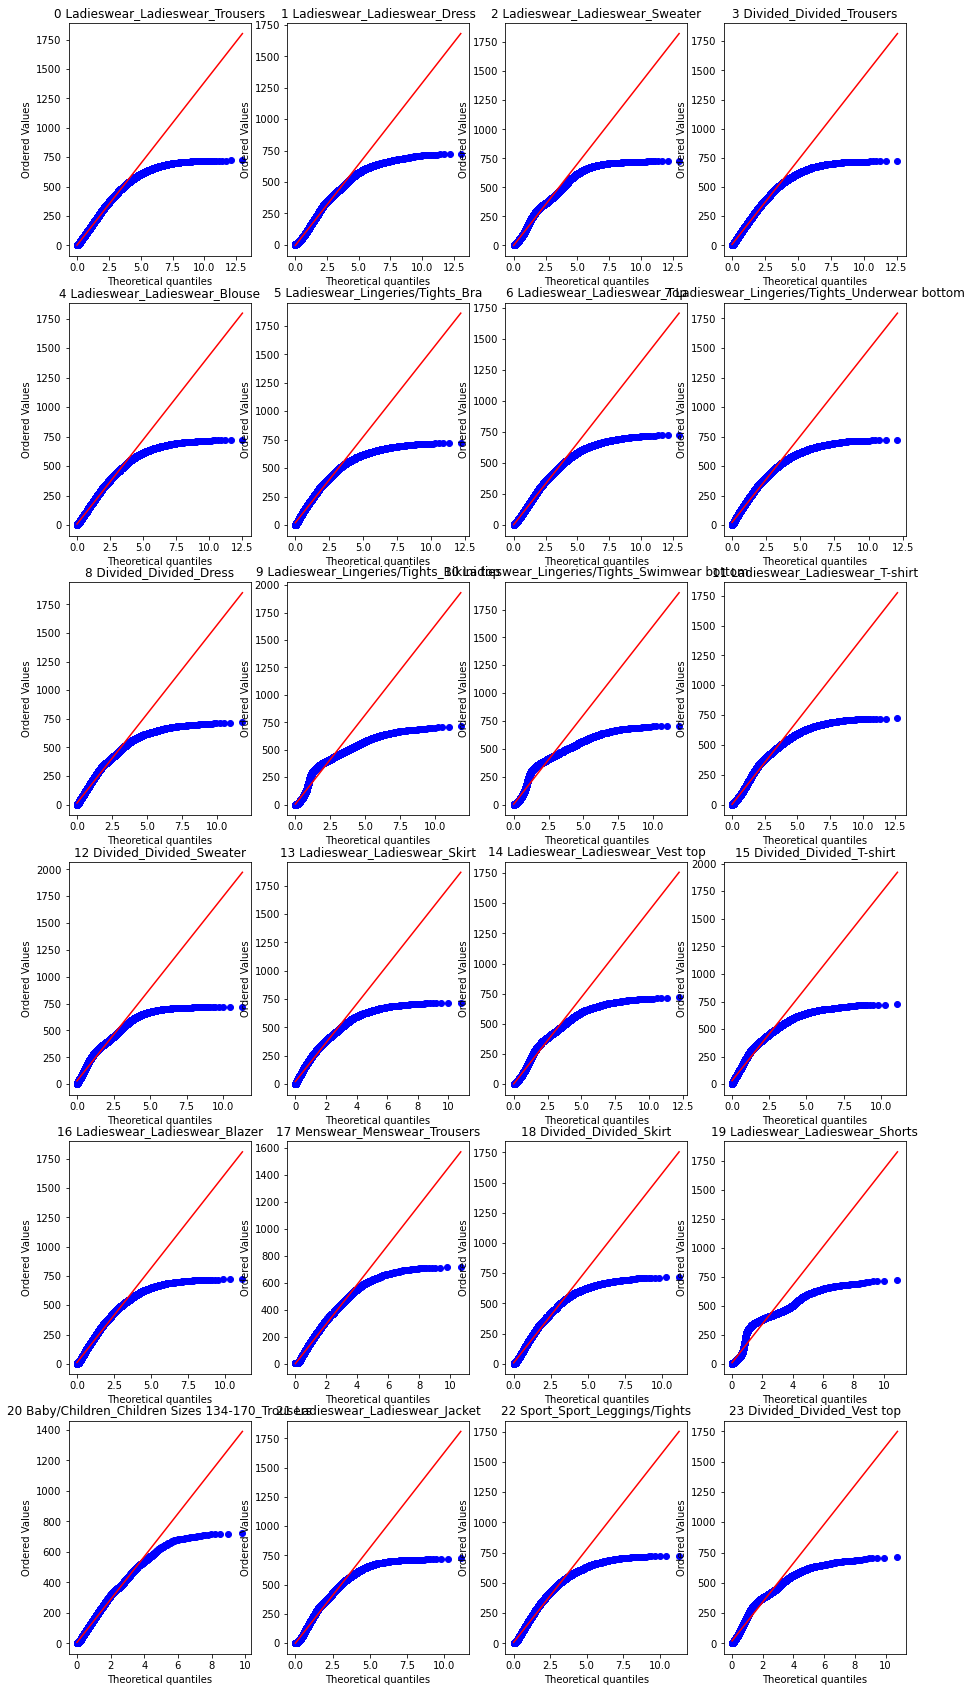

In [78]:
fig = plt.figure(figsize=(15,30))
num_plot = 24
for i in range((num_plot)):
    cur_idxgrp =  rp_idxgrp.idxgrp_idx_prdtyp.iloc[i]
    cur_idxgrp_train_df = idxgrp_train_df[idxgrp_train_df.idxgrp_idx_prdtyp == cur_idxgrp]
    cur_dist = cur_idxgrp_train_df.idxgrp_idx_prdtyp_dist
    cur_dist = cur_dist[~np.isnan(cur_dist)]
    
    shape, loc, scale = stats.gamma.fit(cur_dist)
    #print(shape, loc, scale)
    ax = fig.add_subplot(6, 4, i+1)
    res = stats.probplot(cur_dist, dist=stats.gamma, sparams=(shape,), plot=plt)
    title = cur_idxgrp
    ax.set_title(f"{i} {title}")
#     ax.imshow(res)
        

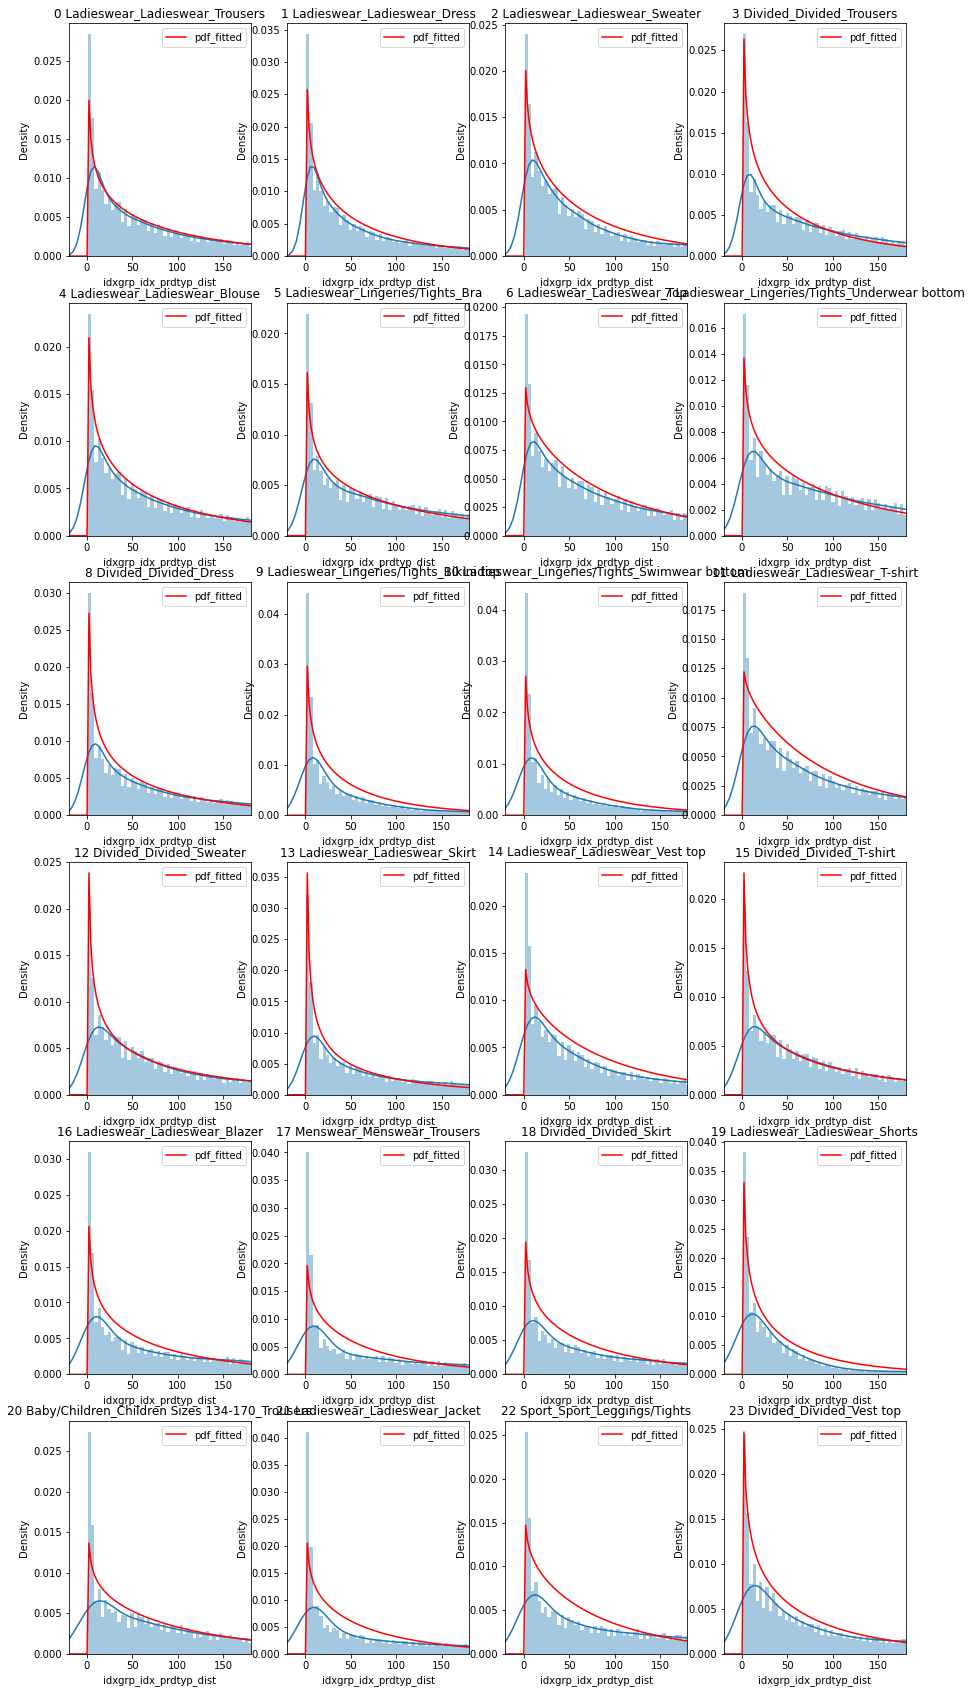

In [80]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

num_plot = 24 
def estimate_distribution(data, dist_name, x_size=100):
    dist = getattr(stats, dist_name)
    params = dist.fit(data)
    mean = params[-2]
    std = params[-1]
    n = data.shape[0]
    x = np.linspace(-20, 180, x_size)
    fitted_pdf = dist.pdf(x, *params[:-2], loc=mean, scale=std) 
    return x, params, fitted_pdf


fig = plt.figure(figsize=(15,30))
for i in range((num_plot)):
    cur_idxgrp =  rp_idxgrp.idxgrp_idx_prdtyp.iloc[i]
    cur_idxgrp_train_df = idxgrp_train_df[idxgrp_train_df.idxgrp_idx_prdtyp == cur_idxgrp]
    cur_dist = cur_idxgrp_train_df.idxgrp_idx_prdtyp_dist
    cur_dist = cur_dist[~np.isnan(cur_dist)]
    
    ax = fig.add_subplot(6, 4, i+1)
    title = cur_idxgrp
    ax.set_title(f"{i} {title}")
    #sns.set(rc={'figure.figsize':(8,8)})
    plt.xlim(-20,180)
    x, params, fitted_pdf = estimate_distribution(cur_dist, 'gamma')

    # sns.distplot(dist, bins=30, norm_hist=False)
    sns.distplot(cur_dist, bins=200, norm_hist=False)
    sns.lineplot(x, fitted_pdf, color='red', label='pdf_fitted')
    
